# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [3]:
%%writefile height_1_ppc.stan

data {
  int<lower=0> N; // number of observations
}

parameters {
  real<lower=0, upper=250> mu; // mean height
  real<lower=0> sigma; // standard deviation of height
}

model {
  // prior on mu
  mu ~ normal(160, 7); // reasonable mean height of 160cm with standard deviation of 10cm
  
  // prior on sigma
  sigma ~ cauchy(0, 10); // Cauchy prior with location 0 and scale 10, representing our uncertainty about the measurement error being on average 15cm
}

generated quantities {
  real new_height = normal_rng(mu, sigma); // simulate a new height from the posterior distribution
}


Overwriting height_1_ppc.stan


In [4]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(data={'N': len(d)},
                     iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=30032023,refresh=R)
print(d['height'])

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab4/height_1_ppc.stan to exe file /root/Data_Analytics/lab4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
534    162.560
537    142.875
540    162.560
541    156.210
543    158.750
Name: height, Length: 352, dtype: float64




1. Plot histograms of mu, sigma and simulated height.


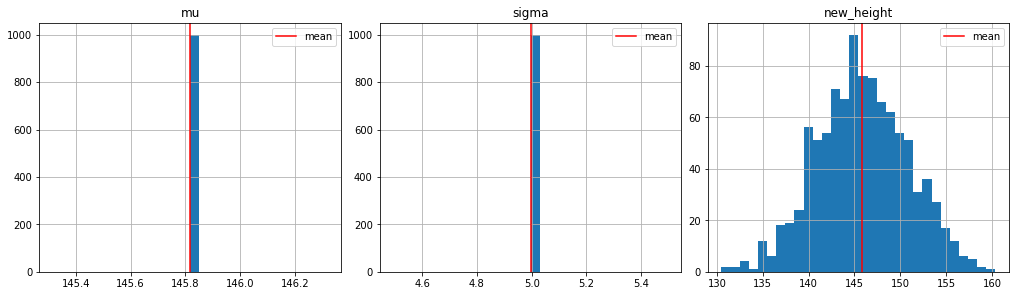

In [5]:
df = sim.draws_pd()
_, ax = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
ax = ax.flatten()
params = ['mu', 'sigma', 'new_height']
for i, param in enumerate(params):
    ax[i].hist(df[param], bins=30)
    ax[i].axvline(df[param].mean(), color='r', label="mean")
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title(param)


2. Plot a joint distribution of mu and sigma.


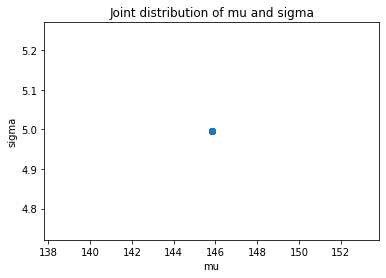

In [6]:
# create a scatter plot of mu vs. sigma
plt.scatter(df['mu'], df['sigma'], alpha=0.5)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Joint distribution of mu and sigma')
plt.show()


3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

## Task 2. Model fit and evaluation

In [7]:
%%writefile height_1_fit.stan

data {
  int<lower=0> N; // number of observations
  real<lower=0, upper=250> heights[N]; // observed heights
}

parameters {
  real<lower=0, upper=250> mu; // mean height
  real<lower=0> sigma; // standard deviation of height
}

model {
  // prior on mu
  mu ~ normal(165, 10); // reasonable mean height of 165cm with standard deviation of 10cm
  
  // prior on sigma
  sigma ~ cauchy(0, 10); // Cauchy prior with location 0 and scale 10, representing our uncertainty about the measurement error being on average 15cm
  
  // likelihood
  heights ~ normal(mu, sigma); // the observed heights are normally distributed around the mean with standard deviation sigma
}

generated quantities {
  real new_height = normal_rng(mu, sigma); // simulate a new height from the posterior distribution
}


Overwriting height_1_fit.stan


In [8]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab4/height_1_fit.stan to exe file /root/Data_Analytics/lab4/height_1_fit
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab4/height_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab4/height_1_fit.hpp /root/Data_Analytics/lab4/height_1_fit.stan
Warning in '/root/Data_Analytics/lab4/height_1_fit.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/li

In [13]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=123456)
df = fit.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.


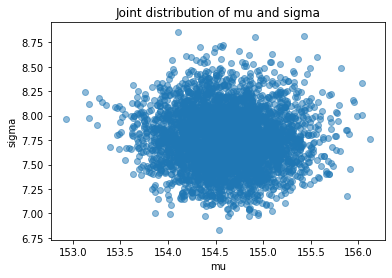

In [14]:
# create a scatter plot of mu vs. sigma
plt.scatter(df['mu'], df['sigma'], alpha=0.5)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Joint distribution of mu and sigma')
plt.show()


2. Plot histograms of data and simulated heights and evaluate the quality of model.


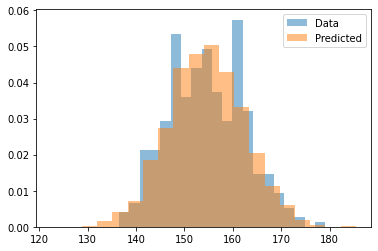

In [15]:
plt.hist(d.height.values, bins=20, density=True, alpha=0.5, label='Data')
plt.hist(df["new_height"], bins=20, density=True, alpha=0.5, label='Predicted')
plt.legend()
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [17]:
d['c_weight'] = d['weight'] - d['weight'].mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
d


,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614
...,...,...,...,...,...
534,162.560,47.031821,27.0,0,2.041335
537,142.875,34.246196,31.0,0,-10.744290
540,162.560,52.163080,31.0,1,7.172594
541,156.210,54.062497,21.0,0,9.072011


## Task 4. Prior predictive checks
 

In [30]:
%%writefile height_2a_ppc.stan

data {
  int<lower=0> N; // number of observations
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(165, 10);
  real beta = normal_rng(0, 1);
  real sigma = normal_rng(0, 10);
  
  real height[N];
  for (i in 1:N) 
   {
      height[i] = normal_rng(alpha + beta * weight[i], sigma);
   }
}

Overwriting height_2a_ppc.stan


In [32]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)
df = sim.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

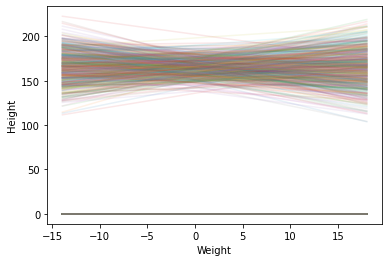

In [35]:
w = np.linspace(min(d.c_weight), max(d.c_weight), num=len(df))
for alpha, beta in zip(df['alpha'], df['beta']):
    plt.plot(w, alpha + beta * w, alpha=0.1)
    
plt.xlabel("Weight")
plt.ylabel("Height")
    
plt.show()

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [36]:
%%writefile height_2b_ppc.stan

data {
  int<lower=0> N; // number of observations
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(165, 10);
  real beta = lognormal_rng(0, 1);
  real sigma = cauchy_rng(0, 10);
  
  real height[N];
  for (i in 1:N) 
   {
      height[i] = normal_rng(alpha + beta * weight[i], sigma);
   }
}

Writing height_2b_ppc.stan


In [37]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab4/height_2b_ppc.stan to exe file /root/Data_Analytics/lab4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab4/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab4/height_2b_ppc.hpp /root/Data_Analytics/lab4/height_2b_ppc.stan
Warning in '/root/Data_Analytics/lab4/height_2b_ppc.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/Data_Analytics/lab4/height_2b_ppc.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to


In [38]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)
df = sim.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.


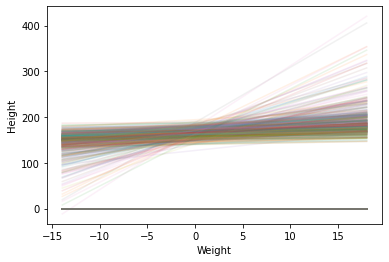

In [39]:
w = np.linspace(min(d.c_weight), max(d.c_weight), num=len(df))
for alpha, beta in zip(df['alpha'], df['beta']):
    plt.plot(w, alpha + beta * w, alpha=0.1)
    
plt.xlabel("Weight")
plt.ylabel("Height")
    
plt.show()


2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [43]:
df.columns

Index(['lp__', 'accept_stat__', 'alpha', 'beta', 'sigma', 'height[1]',
       'height[2]', 'height[3]', 'height[4]', 'height[5]', 'height[6]',
       'height[7]', 'height[8]', 'height[9]', 'height[10]', 'height[11]',
       'height[12]', 'height[13]', 'height[14]', 'height[15]', 'height[16]',
       'height[17]', 'height[18]', 'height[19]', 'height[20]', 'height[21]',
       'height[22]', 'height[23]', 'height[24]', 'height[25]', 'height[26]',
       'height[27]', 'height[28]', 'height[29]', 'height[30]', 'height[31]',
       'height[32]', 'height[33]', 'height[34]', 'height[35]', 'height[36]',
       'height[37]', 'height[38]', 'height[39]', 'height[40]', 'height[41]',
       'height[42]', 'height[43]', 'height[44]', 'height[45]', 'height[46]',
       'height[47]', 'height[48]', 'height[49]', 'height[50]'],
      dtype='object')

In [45]:
heights = df.loc[:, 'height[1]':]

height_sim = df['height']
# Calculate the maximum, minimum, and 5, 25, 50, 75, 95 quantiles of the simulated heights for each weight
height_sim_quantiles = np.quantile(height_sim, q=[0.05, 0.25, 0.5, 0.75, 0.95], axis=0)
height_sim_min = np.min(height_sim, axis=0)
height_sim_max = np.max(height_sim, axis=0)

# Plot the simulated quantiles and observed data
weight_obs = d.c_weight
fig, ax = plt.subplots()
ax.fill_between(weight_obs, height_sim_quantiles[0], height_sim_quantiles[4], alpha=0.2)
ax.fill_between(weight_obs, height_sim_quantiles[1], height_sim_quantiles[3], alpha=0.4)
ax.plot(weight_obs, height_sim_quantiles[2], 'k-')
ax.plot(weight_obs, height_sim_min, 'r--')
ax.plot(weight_obs, height_sim_max, 'r--')
ax.scatter(weight_obs, height_obs)
ax.set_xlabel('Weight (kg)')
ax.set_ylabel('Height (cm)')
ax.set_title('Simulated Heights vs. Observed Data')
plt.show()


KeyError: 'height'

## Task 6. Fitting and evaluating model


In [ ]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [ ]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 